# example1 — Rd(N′) sweep with NMC

This notebook performs a sweep of the **reduced scattering coefficient** (via N′ = μs′/μa) in a homogeneous slab and compares the **diffuse reflectance** `R_d` computed by NMC with the **Farrell diffusion-theory** prediction.

**Workflow**

1. Define user parameters, grid, and homogeneous optical properties.  
2. Sweep the scattering coefficient μ<sub>s</sub> over `N_runs` (typically in log-space), keeping μ<sub>a</sub> fixed.  
3. For each run, write the input files `test_H.mci` and `test_T.bin`.  
4. (Optional) Run the external NMC binary: `./nmc test` (if present in the working directory).  
5. Load the outputs `test_Rd.dat`, `test_Ryx.dat`, and `test_DetPhot2D.dat` (if available).  
6. Compute the diffuse reflectance `R_d` from MC and the corresponding diffusion-theory `R_d` (Farrell model).  
7. Plot `R_d` versus N′ on a semilogarithmic scale and compare Monte Carlo results to diffusion theory.

> If the NMC binary is not found, the notebook plots only the diffusion-theory curve and skips MC execution.


In [1]:
# === Imports & helper (Farrell diffuse reflectance) ===
import os, math, subprocess, shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

nmcdir  = Path('../NMC/DerivedData/NMC/Build/Products/Release')
# Use nmcdir if it exists; otherwise stay in current dir to avoid errors.
if nmcdir.exists():
    os.chdir(nmcdir)
print('Working directory:', Path.cwd())

def get_rd_farrell(mua, musp, n_ratio):
    """Vectorized Farrell diffuse reflectance (Farrell et al., Med. Phys. 19:879–888, 1992).
    Parameters
    ----------
    mua : float
        Absorption coefficient (e.g., mm^-1)
    musp : float
        Reduced scattering coefficient (e.g., mm^-1)
    n_ratio : float
        Index ratio n_tissue / n_outside (scalar)
    Returns
    -------
    float
        Diffuse reflectance Rd
    """
    ri = 0.6681 + 0.0636*n_ratio + 0.7099/n_ratio - 1.4399/(n_ratio**2)
    A = (1.0 + ri) / (1.0 - ri)
    zo = 1.0 / (mua + musp)
    D = zo / 3.0
    delta = np.sqrt(D / mua)
    mueff = 1.0 / delta
    ap = musp / (mua + musp)
    Rd = ap * np.exp(-mueff * zo) / 2.0 * (1.0 + np.exp(-(4.0/3.0) * A * np.sqrt(3.0 * (1.0 - ap))))
    return float(Rd)



Working directory: /Users/aledoronin/Desktop/NMC_framework/NMC/DerivedData/NMC/Build/Products/Release


In [2]:
# === User parameters (edit as needed) ===
SAVEON       = 1     # 1 = write myname_T.bin & myname_H.mci
runON        = 1     # 1 = run NMC if present, 0 = skip run
myname       = "test"
time_min     = 1      # [min] (ignored by kernel; kept for compatibility)
binsize      = 0.02   # [mm]
NBINS        = 200
lambda_mm    = 640.0e-6  # [mm]
lc           = 0.001     # coherence length [mm] (placeholder)

# Monte Carlo flags
mcflag       = 4      # 0=uniform,1=Gaussian,2=isotropic pt.,3=rect beam,4=reserved/custom
launchflag   = 0      # 0=auto launch vector, 1=manual ux0,uy0,uz0
boundaryflag = 0      # 0=no boundaries, 1=escape at all, 2=escape at surface only
mckernelflag = 1      # 0=mcsub,1=mcxyz,2=mcxyztt
speckleflag  = 0
semiflag     = 1

# Source / detector geometry
zsurf    = 0.0
xs, ys, zs   = 0.0, 0.0, 0.0
xfocus, yfocus, zfocus = 0.0, 0.0, float("inf")
radius   = 1.0     # [mm] 1/e radius of beam at surface
det_radius = 5.0   # [mm]
separation = 0.0   # [mm]
waist    = radius  # [mm]

# Manual launch (only used if launchflag==1)
ux0, uy0 = 0.7, 0.4
uz0 = float(np.sqrt(max(1.0 - ux0**2 - uy0**2, 0.0)))

# Optical properties and sweep
Nruns = 10
mua   = 10.0
g_f   = 0.9   # used for mcsub/mcxyz; plays role of 'gf' in MATLAB
a_f, g_b, a_b, C_C = 0.5, 0.9, 0.5, 1.0  # HG params used only when mckernelflag==2

n1, n2 = 1.001, 1.4
na     = 90.0   # numerical aperture (deg), passed through unchanged here

# Grid
dx = dy = dz = binsize
Nx = Ny = Nz = NBINS
x = (np.arange(1, Nx+1) - Nx/2) * dx
y = (np.arange(1, Ny+1) - Ny/2) * dy
z = np.arange(1, Nz+1) * dz

In [3]:
# === Helpers ===
def get_log_scale(x0, xmax, N):
    # Create N log-spaced values from x0 to xmax inclusive (MATLAB getlogscale)
    ii = np.arange(N, dtype=float)
    f = np.exp(np.log(xmax/x0) / max(N-1, 1))
    return x0 * (f ** ii)

def write_mci_and_tbin(myname, params, T):
    # Write myname_H.mci and myname_T.bin following NMC expectations
    with open(f"{myname}_H.mci", "w") as fid:
        fid.write(f"{params['time_min']:.2f}\n")
        fid.write(f"{params['Nx']}\n")
        fid.write(f"{params['Ny']}\n")
        fid.write(f"{params['Nz']}\n")
        fid.write(f"{params['dx']:.4f}\n")
        fid.write(f"{params['dy']:.4f}\n")
        fid.write(f"{params['dz']:.4f}\n")
        fid.write(f"{params['mcflag']}\n")
        fid.write(f"{params['launchflag']}\n")
        fid.write(f"{params['boundaryflag']}\n")
        fid.write(f"{params['xs']:.4f}\n")
        fid.write(f"{params['ys']:.4f}\n")
        fid.write(f"{params['zs']:.4f}\n")
        fid.write(f"{params['xfocus']:.4f}\n")
        fid.write(f"{params['yfocus']:.4f}\n")
        fid.write(f"{params['zfocus']:.4f}\n")
        fid.write(f"{params['ux0']:.4f}\n")
        fid.write(f"{params['uy0']:.4f}\n")
        fid.write(f"{params['uz0']:.4f}\n")
        fid.write(f"{params['radius']:.4f}\n")
        fid.write(f"{params['waist']:.4f}\n")
        fid.write(f"{params['zsurf']:.4f}\n")
        fid.write(f"{params['det_radius']:.4f}\n")
        fid.write(f"{params['separation']:.4f}\n")
        fid.write(f"{params['n1']:.4f}\n")
        fid.write(f"{params['n2']:.4f}\n")
        fid.write(f"{params['na']:.4f}\n")
        fid.write(f"{params['lambda_mm']:.4f}\n")
        fid.write(f"{params['lc']:.4f}\n")
        fid.write(f"{params['speckleflag']}\n")
        fid.write(f"{params['semiflag']}\n")
        fid.write(f"{params['det_state']}\n")
        fid.write(f"{params['mckernelflag']}\n")
        fid.write("1\n")
        fid.write(f"{params['mua']:.4f}\n")
        fid.write(f"{params['mus']:.4f}\n")
        if params['mckernelflag'] < 2:
            fid.write(f"{params['g_f']:.4f}\n")
        else:
            fid.write(f"{params['g_f']:.4f}\n")
            fid.write(f"{params['a_f']:.4f}\n")
            fid.write(f"{params['g_b']:.4f}\n")
            fid.write(f"{params['a_b']:.4f}\n")
            fid.write(f"{params['C_C']:.4f}\n")
    v = T.astype(np.uint8).ravel(order="F")
    with open(f"{myname}_T.bin", "wb") as fid:
        fid.write(v.tobytes())

def maybe_run_nmc(runON=True):
    exe = Path("./nmc")
    if runON and exe.exists() and os.access(exe, os.X_OK):
        print("Running './nmc test' ...")
        rc = subprocess.call(["./nmc", "test"])
        print("Return code:", rc)
        return rc == 0
    else:
        print("NMC binary not found or runON=0; skipping execution.")
        return False


In [4]:
# === Build sweep of mus and run ===
T = np.ones((int(Ny), int(Nx), int(Nz)), dtype=np.uint8)
ms = get_log_scale(0.1, 1e7, Nruns)
rd = np.zeros(Nruns, dtype=float)
Ryx = None
Photyx = None
k1 = 3  # MATLAB 1-based; we'll store when k==(k1-1)

for k in range(Nruns):
    mus_k = float(ms[k])
    print(f"Run {k+1}/{Nruns} : mus = {mus_k:.6g}")
    params = dict(
        time_min=time_min, Nx=int(Nx), Ny=int(Ny), Nz=int(Nz),
        dx=float(dx), dy=float(dy), dz=float(dz),
        mcflag=int(mcflag), launchflag=int(launchflag), boundaryflag=int(boundaryflag),
        xs=float(xs), ys=float(ys), zs=float(zs),
        xfocus=float(xfocus), yfocus=float(yfocus), zfocus=(1e12 if math.isinf(zfocus) else float(zfocus)),
        ux0=float(ux0), uy0=float(uy0), uz0=float(uz0),
        radius=float(radius), waist=float(waist), zsurf=float(zsurf),
        det_radius=float(det_radius), separation=float(separation),
        n1=float(n1), n2=float(n2), na=float(na), lambda_mm=float(lambda_mm), lc=float(lc),
        speckleflag=int(speckleflag), semiflag=int(semiflag),
        det_state=0, mckernelflag=int(mckernelflag),
        mua=float(mua), mus=mus_k, g_f=float(g_f), a_f=float(a_f), g_b=float(g_b), a_b=float(a_b), C_C=float(C_C)
    )
    if SAVEON:
        T[:] = 1
        write_mci_and_tbin(myname, params, T)
    ran = maybe_run_nmc(runON)
    rd_path = Path(f"{myname}_Rd.dat")
    if rd_path.exists():
        try:
            with open(rd_path, "r") as f:
                txt = f.read().strip().split()
                rd[k] = float(txt[0])
        except Exception:
            rd[k] = float(np.loadtxt(rd_path).reshape(-1)[0])
    else:
        rd[k] = np.nan
    if k == (k1 - 1):
        ryx_path = Path(f"{myname}_Ryx.dat")
        phot_path = Path("test_DetPhot2D.dat")
        if ryx_path.exists():
            Ryx = np.loadtxt(ryx_path)
        if phot_path.exists():
            Photyx = np.loadtxt(phot_path)


Run 1/10 : mus = 0.1
Running './nmc test' ...


2025-12-16 09:27:03.022 nmc[4095:230563] AMD Radeon Pro 5500 XT


name = test
Welcome to mcxyz...
time_min = 1.00 min
Nx = 200, dx = 0.0200 [mm]
Ny = 200, dy = 0.0200 [mm]
Nz = 200, dz = 0.0200 [mm]
xs = 0.0000 [mm]
ys = 0.0000 [mm]
zs = 0.0000 [mm]
mcflag = 4 [mm]
xfocus = 0.0000 [mm]
yfocus = 0.0000 [mm]
zfocus = 1.00e+12 [mm]
Launchflag OFF, so program calculates launch angles.
radius = 1.0000 [mm]
waist  = 1.0000 [mm]
zsurf  = 0.0000 [mm]
boundaryflag = 0, so no boundaries.
performing mcxyz
# of tissues available, Nt = 1
muav[1] = 10.0000 [mm^-1]
musv[1] = 0.1000 [mm^-1]
  gv[1] = 0.9000 [--]

n1 = 1.0010 [mm]
n2 = 1.4000 [mm]
central axial profile of tissue types:
11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

Getting simulation results
Total execution time (GPU):0.846177
Simulation rate 118178 [photons/sec]
saving test_F.bin
------------------------------------------------------
Total Rd = 0.

2025-12-16 09:27:05.106 nmc[4102:230655] AMD Radeon Pro 5500 XT


name = test
Welcome to mcxyz...
time_min = 1.00 min
Nx = 200, dx = 0.0200 [mm]
Ny = 200, dy = 0.0200 [mm]
Nz = 200, dz = 0.0200 [mm]
xs = 0.0000 [mm]
ys = 0.0000 [mm]
zs = 0.0000 [mm]
mcflag = 4 [mm]
xfocus = 0.0000 [mm]
yfocus = 0.0000 [mm]
zfocus = 1.00e+12 [mm]
Launchflag OFF, so program calculates launch angles.
radius = 1.0000 [mm]
waist  = 1.0000 [mm]
zsurf  = 0.0000 [mm]
boundaryflag = 0, so no boundaries.
performing mcxyz
# of tissues available, Nt = 1
muav[1] = 10.0000 [mm^-1]
musv[1] = 0.7743 [mm^-1]
  gv[1] = 0.9000 [--]

n1 = 1.0010 [mm]
n2 = 1.4000 [mm]
central axial profile of tissue types:
11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

Getting simulation results
Total execution time (GPU):0.826597
Simulation rate 120977 [photons/sec]
saving test_F.bin
------------------------------------------------------
Total Rd = 0.

2025-12-16 09:27:07.158 nmc[4106:230708] AMD Radeon Pro 5500 XT


name = test
Welcome to mcxyz...
time_min = 1.00 min
Nx = 200, dx = 0.0200 [mm]
Ny = 200, dy = 0.0200 [mm]
Nz = 200, dz = 0.0200 [mm]
xs = 0.0000 [mm]
ys = 0.0000 [mm]
zs = 0.0000 [mm]
mcflag = 4 [mm]
xfocus = 0.0000 [mm]
yfocus = 0.0000 [mm]
zfocus = 1.00e+12 [mm]
Launchflag OFF, so program calculates launch angles.
radius = 1.0000 [mm]
waist  = 1.0000 [mm]
zsurf  = 0.0000 [mm]
boundaryflag = 0, so no boundaries.
performing mcxyz
# of tissues available, Nt = 1
muav[1] = 10.0000 [mm^-1]
musv[1] = 5.9948 [mm^-1]
  gv[1] = 0.9000 [--]

n1 = 1.0010 [mm]
n2 = 1.4000 [mm]
central axial profile of tissue types:
11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

Getting simulation results
Total execution time (GPU):0.807830
Simulation rate 123788 [photons/sec]
saving test_F.bin
------------------------------------------------------
Total Rd = 0.

2025-12-16 09:27:09.208 nmc[4110:230741] AMD Radeon Pro 5500 XT


name = test
Welcome to mcxyz...
time_min = 1.00 min
Nx = 200, dx = 0.0200 [mm]
Ny = 200, dy = 0.0200 [mm]
Nz = 200, dz = 0.0200 [mm]
xs = 0.0000 [mm]
ys = 0.0000 [mm]
zs = 0.0000 [mm]
mcflag = 4 [mm]
xfocus = 0.0000 [mm]
yfocus = 0.0000 [mm]
zfocus = 1.00e+12 [mm]
Launchflag OFF, so program calculates launch angles.
radius = 1.0000 [mm]
waist  = 1.0000 [mm]
zsurf  = 0.0000 [mm]
boundaryflag = 0, so no boundaries.
performing mcxyz
# of tissues available, Nt = 1
muav[1] = 10.0000 [mm^-1]
musv[1] = 46.4159 [mm^-1]
  gv[1] = 0.9000 [--]

n1 = 1.0010 [mm]
n2 = 1.4000 [mm]
central axial profile of tissue types:
11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

Getting simulation results
Total execution time (GPU):0.812994
Simulation rate 123002 [photons/sec]
saving test_F.bin
------------------------------------------------------
Total Rd = 0

2025-12-16 09:27:11.251 nmc[4111:230769] AMD Radeon Pro 5500 XT


name = test
Welcome to mcxyz...
time_min = 1.00 min
Nx = 200, dx = 0.0200 [mm]
Ny = 200, dy = 0.0200 [mm]
Nz = 200, dz = 0.0200 [mm]
xs = 0.0000 [mm]
ys = 0.0000 [mm]
zs = 0.0000 [mm]
mcflag = 4 [mm]
xfocus = 0.0000 [mm]
yfocus = 0.0000 [mm]
zfocus = 1.00e+12 [mm]
Launchflag OFF, so program calculates launch angles.
radius = 1.0000 [mm]
waist  = 1.0000 [mm]
zsurf  = 0.0000 [mm]
boundaryflag = 0, so no boundaries.
performing mcxyz
# of tissues available, Nt = 1
muav[1] = 10.0000 [mm^-1]
musv[1] = 359.3814 [mm^-1]
  gv[1] = 0.9000 [--]

n1 = 1.0010 [mm]
n2 = 1.4000 [mm]
central axial profile of tissue types:
11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

Getting simulation results
Total execution time (GPU):1.475868
Simulation rate 67756 [photons/sec]
saving test_F.bin
------------------------------------------------------
Total Rd = 0

2025-12-16 09:27:13.984 nmc[4112:230792] AMD Radeon Pro 5500 XT


name = test
Welcome to mcxyz...
time_min = 1.00 min
Nx = 200, dx = 0.0200 [mm]
Ny = 200, dy = 0.0200 [mm]
Nz = 200, dz = 0.0200 [mm]
xs = 0.0000 [mm]
ys = 0.0000 [mm]
zs = 0.0000 [mm]
mcflag = 4 [mm]
xfocus = 0.0000 [mm]
yfocus = 0.0000 [mm]
zfocus = 1.00e+12 [mm]
Launchflag OFF, so program calculates launch angles.
radius = 1.0000 [mm]
waist  = 1.0000 [mm]
zsurf  = 0.0000 [mm]
boundaryflag = 0, so no boundaries.
performing mcxyz
# of tissues available, Nt = 1
muav[1] = 10.0000 [mm^-1]
musv[1] = 2782.5593 [mm^-1]
  gv[1] = 0.9000 [--]

n1 = 1.0010 [mm]
n2 = 1.4000 [mm]
central axial profile of tissue types:
11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

Getting simulation results
Total execution time (GPU):2.002023
Simulation rate 49949 [photons/sec]
saving test_F.bin
------------------------------------------------------
Total Rd = 

2025-12-16 09:27:17.254 nmc[4115:230862] AMD Radeon Pro 5500 XT


name = test
Welcome to mcxyz...
time_min = 1.00 min
Nx = 200, dx = 0.0200 [mm]
Ny = 200, dy = 0.0200 [mm]
Nz = 200, dz = 0.0200 [mm]
xs = 0.0000 [mm]
ys = 0.0000 [mm]
zs = 0.0000 [mm]
mcflag = 4 [mm]
xfocus = 0.0000 [mm]
yfocus = 0.0000 [mm]
zfocus = 1.00e+12 [mm]
Launchflag OFF, so program calculates launch angles.
radius = 1.0000 [mm]
waist  = 1.0000 [mm]
zsurf  = 0.0000 [mm]
boundaryflag = 0, so no boundaries.
performing mcxyz
# of tissues available, Nt = 1
muav[1] = 10.0000 [mm^-1]
musv[1] = 21544.3477 [mm^-1]
  gv[1] = 0.9000 [--]

n1 = 1.0010 [mm]
n2 = 1.4000 [mm]
central axial profile of tissue types:
11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

Getting simulation results
Total execution time (GPU):4.626340
Simulation rate 21615 [photons/sec]
saving test_F.bin
------------------------------------------------------
Total Rd =

2025-12-16 09:27:23.135 nmc[4116:230955] AMD Radeon Pro 5500 XT


name = test
Welcome to mcxyz...
time_min = 1.00 min
Nx = 200, dx = 0.0200 [mm]
Ny = 200, dy = 0.0200 [mm]
Nz = 200, dz = 0.0200 [mm]
xs = 0.0000 [mm]
ys = 0.0000 [mm]
zs = 0.0000 [mm]
mcflag = 4 [mm]
xfocus = 0.0000 [mm]
yfocus = 0.0000 [mm]
zfocus = 1.00e+12 [mm]
Launchflag OFF, so program calculates launch angles.
radius = 1.0000 [mm]
waist  = 1.0000 [mm]
zsurf  = 0.0000 [mm]
boundaryflag = 0, so no boundaries.
performing mcxyz
# of tissues available, Nt = 1
muav[1] = 10.0000 [mm^-1]
musv[1] = 166810.0469 [mm^-1]
  gv[1] = 0.9000 [--]

n1 = 1.0010 [mm]
n2 = 1.4000 [mm]
central axial profile of tissue types:
11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

Getting simulation results
Total execution time (GPU):5.236190
Simulation rate 19097 [photons/sec]
saving test_F.bin
------------------------------------------------------
Total Rd 

2025-12-16 09:27:29.622 nmc[4122:231052] AMD Radeon Pro 5500 XT


name = test
Welcome to mcxyz...
time_min = 1.00 min
Nx = 200, dx = 0.0200 [mm]
Ny = 200, dy = 0.0200 [mm]
Nz = 200, dz = 0.0200 [mm]
xs = 0.0000 [mm]
ys = 0.0000 [mm]
zs = 0.0000 [mm]
mcflag = 4 [mm]
xfocus = 0.0000 [mm]
yfocus = 0.0000 [mm]
zfocus = 1.00e+12 [mm]
Launchflag OFF, so program calculates launch angles.
radius = 1.0000 [mm]
waist  = 1.0000 [mm]
zsurf  = 0.0000 [mm]
boundaryflag = 0, so no boundaries.
performing mcxyz
# of tissues available, Nt = 1
muav[1] = 10.0000 [mm^-1]
musv[1] = 1291549.6250 [mm^-1]
  gv[1] = 0.9000 [--]

n1 = 1.0010 [mm]
n2 = 1.4000 [mm]
central axial profile of tissue types:
11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

Getting simulation results
Total execution time (GPU):5.145112
Simulation rate 19435 [photons/sec]
saving test_F.bin
------------------------------------------------------
Total Rd

2025-12-16 09:27:36.024 nmc[4125:231133] AMD Radeon Pro 5500 XT


name = test
Welcome to mcxyz...
time_min = 1.00 min
Nx = 200, dx = 0.0200 [mm]
Ny = 200, dy = 0.0200 [mm]
Nz = 200, dz = 0.0200 [mm]
xs = 0.0000 [mm]
ys = 0.0000 [mm]
zs = 0.0000 [mm]
mcflag = 4 [mm]
xfocus = 0.0000 [mm]
yfocus = 0.0000 [mm]
zfocus = 1.00e+12 [mm]
Launchflag OFF, so program calculates launch angles.
radius = 1.0000 [mm]
waist  = 1.0000 [mm]
zsurf  = 0.0000 [mm]
boundaryflag = 0, so no boundaries.
performing mcxyz
# of tissues available, Nt = 1
muav[1] = 10.0000 [mm^-1]
musv[1] = 10000000.0000 [mm^-1]
  gv[1] = 0.9000 [--]

n1 = 1.0010 [mm]
n2 = 1.4000 [mm]
central axial profile of tissue types:
11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

Getting simulation results
Total execution time (GPU):5.101653
Simulation rate 19601 [photons/sec]
saving test_F.bin
------------------------------------------------------
Total R

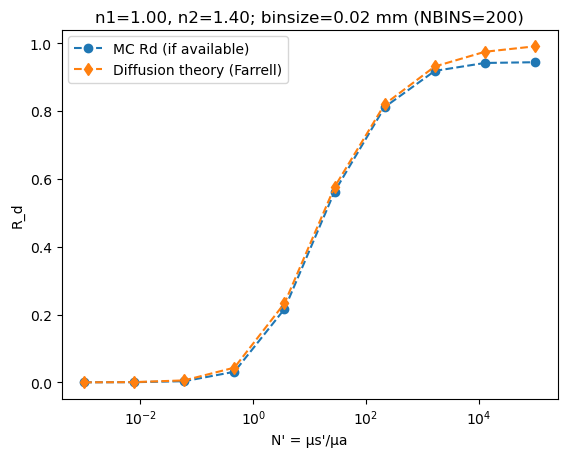

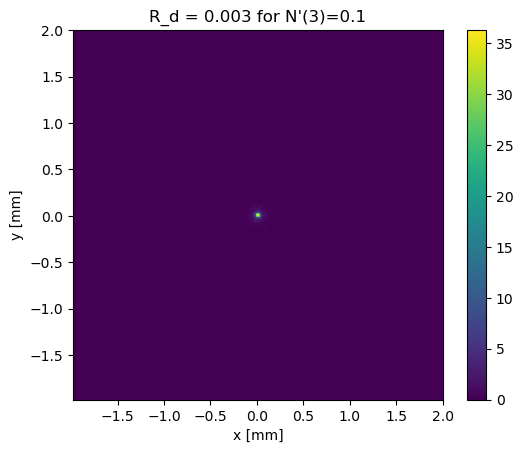

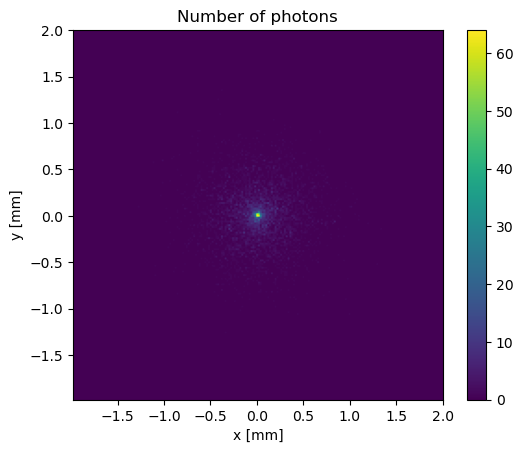

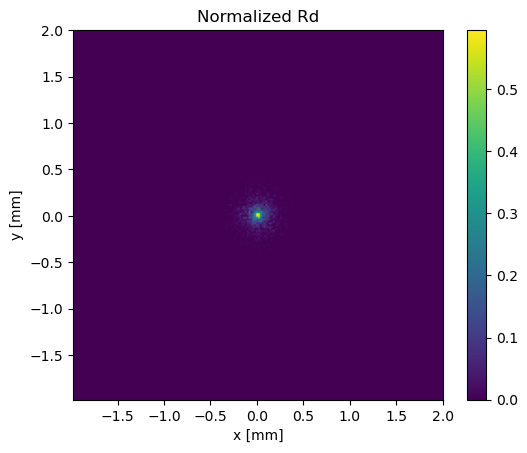

In [6]:
# === Compute diffusion theory and plot ===
msp = ms * (1.0 - g_f)
Np = msp / mua
Rdt = np.array([get_rd_farrell(mua, msp_i, n1) for msp_i in msp])

plt.figure()
plt.semilogx(Np, rd, 'o--', label="MC Rd (if available)")
plt.semilogx(Np, Rdt, 'd--', label="Diffusion theory (Farrell)")
plt.xlabel("N' = μs'/μa")
plt.ylabel("R_d")
plt.title(f"n1={n1:.2f}, n2={n2:.2f}; binsize={binsize:.2f} mm (NBINS={NBINS})")
plt.legend()
plt.show()

if 'Ryx' in globals() and Ryx is not None:
    plt.figure()
    plt.imshow(Ryx, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='equal')
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    title_rd = (rd[k1-1] if (k1-1) < len(rd) and not np.isnan(rd[k1-1]) else float('nan'))
    plt.title(f"R_d = {title_rd:.3f} for N'({k1})={Np[k1-1]:.1f}")
    plt.colorbar()
    plt.show()

if 'Photyx' in globals() and Photyx is not None:
    plt.figure()
    plt.imshow(Photyx, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='equal')
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    plt.title("Number of photons")
    plt.colorbar()
    plt.show()

    if 'Ryx' in globals() and Ryx is not None and Photyx.shape == Ryx.shape:
        a = np.divide(Ryx, Photyx, out=np.zeros_like(Ryx, dtype=float), where=Photyx!=0)
        plt.figure()
        plt.imshow(a, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='equal')
        plt.xlabel("x [mm]")
        plt.ylabel("y [mm]")
        plt.title("Normalized Rd")
        plt.colorbar()
        plt.show()
